In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

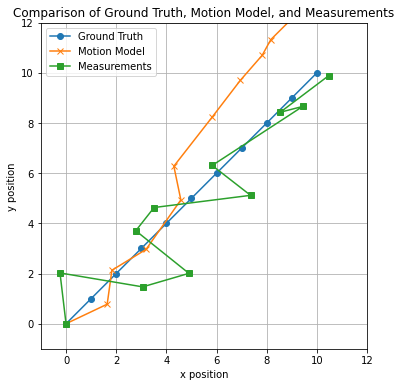

In [7]:
# Generate ground truth states
def generate_ground_truth(num_steps):
    ground_truth_xs = np.linspace(0, 10, num=num_steps + 1)
    ground_truth_ys = ground_truth_xs.copy()
    ground_truth_states = np.stack((ground_truth_xs, ground_truth_ys), axis=1)
    return ground_truth_states

# Simulate motion with noisy motion model
def simulate_motion(initial_state, control_input, A, B, Q, num_steps):
    motion_states = [initial_state]
    for _ in range(num_steps):
        motion_noise = np.random.multivariate_normal(mean=np.array([0,0]), cov=Q)
        new_state = A @ motion_states[-1] + B @ control_input + motion_noise
        motion_states.append(new_state)
    return np.array(motion_states)

# Simulate measurements with noisy measurement model
def simulate_measurements(ground_truth_states, H, R):
    measurement_states = [ground_truth_states[0]]
    for i in range(1, len(ground_truth_states)):
        measurement_noise = np.random.multivariate_normal(mean=np.array([0,0]), cov=R)
        new_measurement = H @ ground_truth_states[i] + measurement_noise
        measurement_states.append(new_measurement)
    return np.array(measurement_states)

# Parameters
num_steps = 10
initial_state = np.array([0, 0])
control_input = np.array([1.0, 1.0])
A = np.array([[1, 0], [0, 1]])
B = np.array([[1, 0], [0, 1]])
Q = np.array([[0.3, 0], [0, 0.3]])
H = np.array([[1, 0], [0, 1]])
R = np.array([[0.75, 0], [0, 0.6]])

# Generate states
ground_truth_states = generate_ground_truth(num_steps)
motion_states = simulate_motion(initial_state, control_input, A, B, Q, num_steps)
measurement_states = simulate_measurements(ground_truth_states, H, R)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(ground_truth_states[:,0], ground_truth_states[:,1], label='Ground Truth', marker='o')
plt.plot(motion_states[:,0], motion_states[:,1], label='Motion Model', marker='x')
plt.plot(measurement_states[:,0], measurement_states[:,1], label='Measurements', marker='s')
plt.xlim(-1, 12)
plt.ylim(-1, 12)
plt.xlabel('x position')
plt.ylabel('y position')
plt.legend()
plt.grid(True)
plt.gca().set_aspect('equal', adjustable='box')
plt.title('Comparison of Ground Truth, Motion Model, and Measurements')
plt.show()

In [9]:
def predict(A, B, Q, u_t, mu_t, Sigma_t):
    """
    Predicts the next state and covariance.

    Parameters:
    A (ndarray): State transition matrix.
    B (ndarray): Control input matrix.
    Q (ndarray): Process noise covariance matrix.
    u_t (ndarray): Control input.
    mu_t (ndarray): Mean of the current state estimate.
    Sigma_t (ndarray): Covariance of the current state estimate.

    Returns:
    predicted_mu (ndarray): Predicted state mean.
    predicted_Sigma (ndarray): Predicted state covariance.
    """
    # Predicted state mean
    predicted_mu = A @ mu_t + B @ u_t
    
    # Predicted state covariance
    predicted_Sigma = A @ Sigma_t @ A.T + Q
    
    return predicted_mu, predicted_Sigma

# Update step of the Kalman Filter
def update(H, R, z, predicted_mu, predicted_Sigma):
    """
    Updates the state estimate and covariance based on the new measurement.

    Parameters:
    H (ndarray): Observation matrix.
    R (ndarray): Measurement noise covariance matrix.
    z (ndarray): Measurement at the current step.
    predicted_mu (ndarray): Predicted state mean.
    predicted_Sigma (ndarray): Predicted state covariance.

    Returns:
    updated_mu (ndarray): Updated state mean.
    updated_Sigma (ndarray): Updated state covariance.
    """
    # Measurement residual (innovation)
    residual = z - H @ predicted_mu
    
    # Residual covariance (innovation covariance)
    residual_covariance = H @ predicted_Sigma @ H.T + R
    
    # Kalman gain
    kalman_gain = predicted_Sigma @ H.T @ np.linalg.inv(residual_covariance)
    
    # Updated state mean
    updated_mu = predicted_mu + kalman_gain @ residual
    
    # Updated state covariance
    updated_Sigma = predicted_Sigma - kalman_gain @ H @ predicted_Sigma
    
    return updated_mu, updated_Sigma

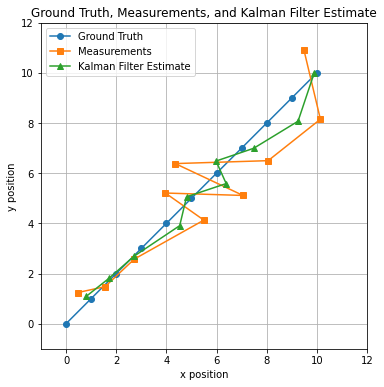

In [10]:
# Parameters
num_steps = 10
mu_0 = np.array([0, 0])  # initial estimate
Sigma_0 = np.array([[0.1, 0], [0, 0.1]])  # initial covariance estimate
u_t = np.array([1, 1])  # constant control input

A = np.array([[1, 0], [0, 1]])
B = np.array([[1, 0], [0, 1]])
Q = np.array([[0.3, 0], [0, 0.3]])
H = np.array([[1, 0], [0, 1]])
R = np.array([[0.75, 0], [0, 0.6]])

# Generate ground truth states
ground_truth_xs = np.linspace(0, 10, num=num_steps + 1)
ground_truth_ys = ground_truth_xs.copy()
ground_truth_states = np.stack((ground_truth_xs, ground_truth_ys), axis=1)

# Initialize empty lists to store the filtered states and measurements for plotting
measurement_states = []
filtered_states = []

# Run Kalman Filter for each time step
mu_current = mu_0.copy()
Sigma_current = Sigma_0.copy()
for i in range(num_steps):
    # Predict step
    predicted_mu, predicted_Sigma = predict(A, B, Q, u_t, mu_current, Sigma_current)
    
    # Get measurement (in real life, we get this from our sensor)
    measurement_noise = np.random.multivariate_normal(mean=np.array([0, 0]), cov=R)  # ~N(0,R)
    new_measurement = H @ ground_truth_states[i + 1] + measurement_noise  # this is z_t
    
    # Update step
    mu_current, Sigma_current = update(H, R, new_measurement, predicted_mu, predicted_Sigma)
    
    # Store measurements and mu_current so we can plot it later
    measurement_states.append(new_measurement)
    filtered_states.append(mu_current)

# Convert lists to arrays for plotting
measurement_states = np.array(measurement_states)
filtered_states = np.array(filtered_states)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(ground_truth_states[:, 0], ground_truth_states[:, 1], label='Ground Truth', marker='o')
plt.plot(measurement_states[:, 0], measurement_states[:, 1], label='Measurements', marker='s')
plt.plot(filtered_states[:, 0], filtered_states[:, 1], label='Kalman Filter Estimate', marker='^')
plt.xlim(-1, 12)
plt.ylim(-1, 12)
plt.xlabel('x position')
plt.ylabel('y position')
plt.legend()
plt.grid(True)
plt.gca().set_aspect('equal', adjustable='box')
plt.title('Ground Truth, Measurements, and Kalman Filter Estimate')
plt.show()
